## How good is Kubelka-Munk at predicting Neugabauer primaries? 
Hopefully better than nothing.

Brief reference:
- this paper does it with KM (w Saunderson correction) with okay results: https://www.researchgate.net/publication/263610258_Predicting_reflectances_of_Neugebauer_primaries_by_relying_on_separately_measured_ink_transmittances

- this paper also does it w/ offset printing: https://libgen.is/scimag/10.4028%2Fwww.scientific.net%2FAMR.174.72

Those papers are 


**Predicting reflectances of Neugebauer primaries by relying on separately measured ink transmittances (2012)**

**The Performance of Computerized Spectrum Color Matching Based on Kubelka-Munk Theory and its Color Rendering on Offset Ink Sets (2010)**


This approach will be naive, loosely based on existing theory, but mostly following my intuition. 

## Loading measured ink spectra

In [1]:
import csv
import numpy as np
from spectra import Spectra, Pigment

In [2]:
primary_fns = [
    "000",
    "001",
    "010",
    "100",
    "011",
    "110",
    "101",
    "111",
]

spectra_primaries_dict = {}
wavelengths = np.arange(400, 701, 10)

for fn in primary_fns:
    with open(f'PrintColors/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths)
                spectra_primaries_dict[fn] = spectra
            

In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
from typing import List, Tuple, Dict, Optional


In [4]:
def k_s_from_pigments(pigments: List[Spectra]) -> Tuple[npt.NDArray, npt.NDArray]:
    k_list = []
    s_list = []

    for pigment in pigments:
        if not isinstance(pigment, Pigment):
            pigment = Pigment(reflectance=pigment)
        k, s = pigment.get_k_s()
        k_list.append(k)
        s_list.append(s)

    k_matrix = np.column_stack(k_list)
    s_matrix = np.column_stack(s_list)

    return k_matrix, s_matrix


In [5]:
def km_mix(pigments : List[Spectra], concentrations : Optional[npt.NDArray] = None) -> Pigment:
    K_matrix, S_matrix = k_s_from_pigments(pigments)
    wavelengths = pigments[0].wavelengths()

    if not concentrations:
        concentrations = np.array([1 / len(pigments)] * len(pigments) )
        
    K_mix = K_matrix @ concentrations
    S_mix = S_matrix @ concentrations
    
    k = np.column_stack((wavelengths, K_mix))
    s = np.column_stack((wavelengths, S_mix))
    
    return Pigment(k=k, s=s)

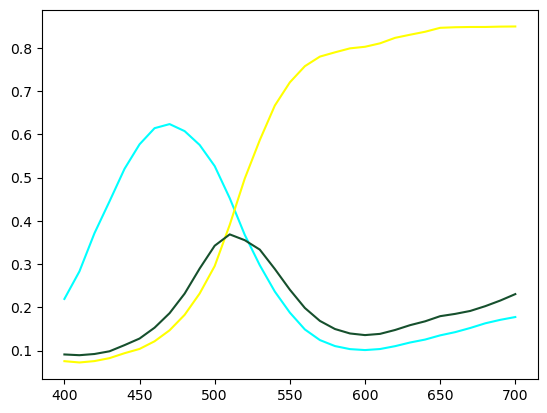

In [6]:
spectra_primaries_dict["100"].plot(color="cyan")
spectra_primaries_dict["001"].plot(color="yellow")
spectra_primaries_dict["101"].plot()
plt.show()

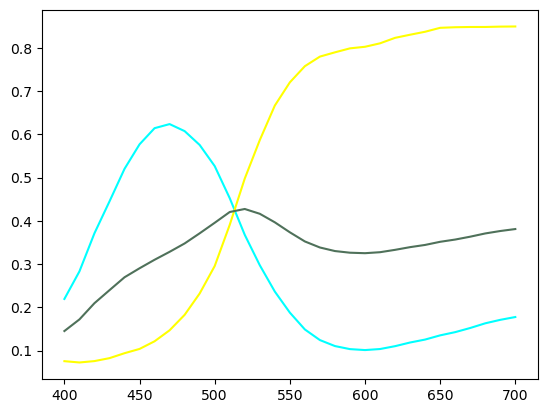

In [7]:
green_paint = km_mix([spectra_primaries_dict["100"], spectra_primaries_dict["001"]])

spectra_primaries_dict["100"].plot(color="cyan")
spectra_primaries_dict["001"].plot(color="yellow")
green_paint.plot()
plt.show()

#### **Hypothesis:**

The *Neugabauer superposition* of inks A and B can be achieved via 

$$ \beta + \alpha \text{KM}(A, B) $$

for constant $\alpha, \beta$. In particular, this should generalize for inks $I_1, I_2, \dots, I_k$ as 

$$ \beta + \alpha \text{KM}(I_1, I_2, \dots, I_k) $$

We can model this as 

$$ Y \sim \beta + \alpha X $$

which can be solved via OLS.

In [8]:
X = np.array([
    km_mix([spectra_primaries_dict[primary] for primary in primaries]).data()
    for primaries in [["100", "001"],
                      ["100", "010"],
                      ["010", "001"],
                      ["100", "010", "001"]]
])

Y = np.array([
    spectra_primaries_dict[mix].data() for mix in ["101","110","011", "111"]
])
print(X.shape)
print(Y.shape)
N, D = X.shape

(4, 31)
(4, 31)


In [9]:
alphas = np.zeros(D)
betas = np.zeros(D)

# Iterate over each dimension
for d in range(D):
    X_d = X[:, d]
    Y_d = Y[:, d]

    # Prepare the design matrix
    Z_d = np.column_stack([X_d, np.ones(N)])

    # Solve for alpha and beta using ordinary least squares (OLS)
    params, _, _, _ = np.linalg.lstsq(Z_d, Y_d, rcond=None)

    # Extract alpha and beta for dimension d
    alphas[d] = params[0]
    betas[d] = params[1]

alpha = np.mean(alphas)
beta = np.mean(betas)
print("alpha:", alpha)
print("beta:", beta)

alpha: 1.1960415083643519
beta: -0.23046295192500518


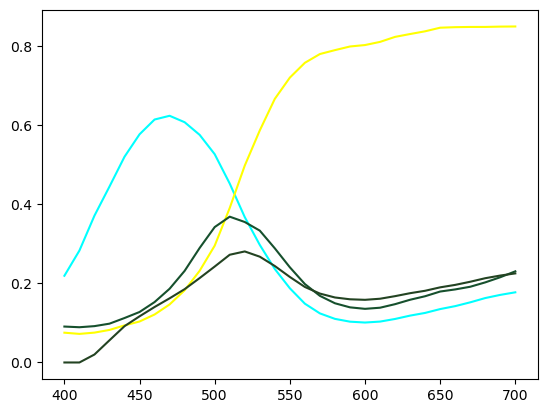

In [10]:
spectra_primaries_dict["100"].plot(color="cyan")
spectra_primaries_dict["001"].plot(color="yellow")
spectra_primaries_dict["101"].plot()
mixed_green = alpha * km_mix([spectra_primaries_dict["100"], spectra_primaries_dict["001"]]) + beta
mixed_green.plot()
plt.show()

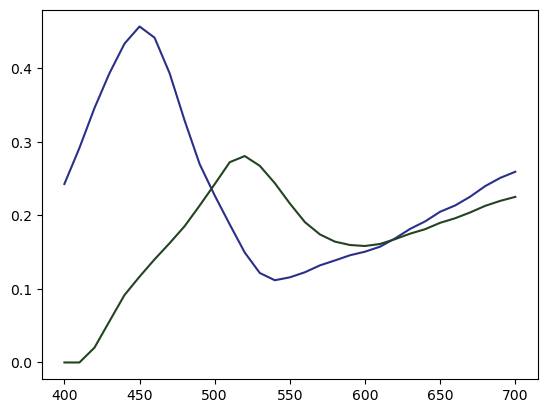

In [11]:
spectra_primaries_dict["110"].plot()
mixed_color =  alpha * km_mix([ spectra_primaries_dict["100"],
                              spectra_primaries_dict["010"],
                             ])  + beta
mixed_green.plot()
plt.show()